In [111]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.neighbors import KernelDensity
from matplotlib.colors import LinearSegmentedColormap

In [112]:
# Đọc tệp shapefile sử dụng GeoPandas
gdf = gpd.read_file('gadm41_VNM_2.shp')
# Lọc tỉnh lấy TP.HCM
gdf_hcm = gdf[gdf['NAME_1'] == 'Há»\x93 ChÃ\xad Minh']

# Đổi tên cột chứa quận thành "District" để đồng nhất với tệp dữ liệu
gdf_hcm = gdf_hcm.rename(columns={'VARNAME_2': 'District'})

# Thay đổi format của dữ liệu tên quận để đồng nhất với tệp dữ liệu
replace_dict = {'Binh Chanh':'binh-chanh', 'Binh Tan' : 'binh-tan','Binh Thanh':'binh-thanh', 'Can Gio':'can-gio', 
 'Cu Chi':'cu-chi', 'Go Vap':'go-vap', 'Hoc Mon':'hoc-mon', 'Nha Be':'nha-be', 'Phu Nhuan':'phu-nhuan', 
 'District 1':'quan-1', 'District 10':'quan-10', 'District 11':'quan-11', 'District 12':'quan-12', 'District 2':'quan-2', 
 'District 3':'quan-3', 'District 4':'quan-4', 'District 5':'quan-5', 'District 6':'quan-6', 'District 7':'quan-7', 
 'District 8':'quan-8', 'District 9':'quan-9', 'Tan Binh':'tan-binh',  'Tan Phu':'tan-phu', 'Thu Duc':'thu-duc'}
gdf_hcm['District'] = gdf_hcm['District'].replace(replace_dict)

In [113]:
# Đọc tệp dữ liệu đã được làm sạch
df = pd.read_csv('data_with_district.csv')
df = df[['District','Price_per_sqm','Month']]
df = gdf_hcm.merge(df, on='District')
# df = df[['District','Price_per_sqm','Month', 'geometry']]
df.to_csv('data1.csv', index = False)

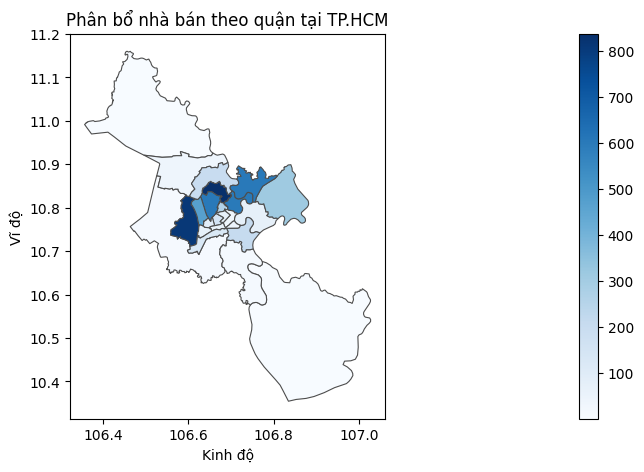

In [114]:
# Chuẩn bị dữ liệu số lượng nhà bán theo quận
district_counts = df['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Counts']

# Hợp nhất dữ liệu số lượng nhà bán với dữ liệu bản đồ hành chính
gdf = gdf_hcm.merge(district_counts, on='District')


# Vẽ bản đồ nhiệt
fig, ax = plt.subplots(1, 1, figsize=(50, 5))

gdf.plot(column='Counts', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)
# gdf.plot(linewidth=0.8, ax=ax, edgecolor='0.3', legend=True, color='white')

plt.title('Phân bổ nhà bán theo quận tại TP.HCM')
plt.xlabel('Kinh độ')
plt.ylabel('Vĩ độ')
plt.show()

TypeError: Colorbar.__init__() got an unexpected keyword argument 'levels'

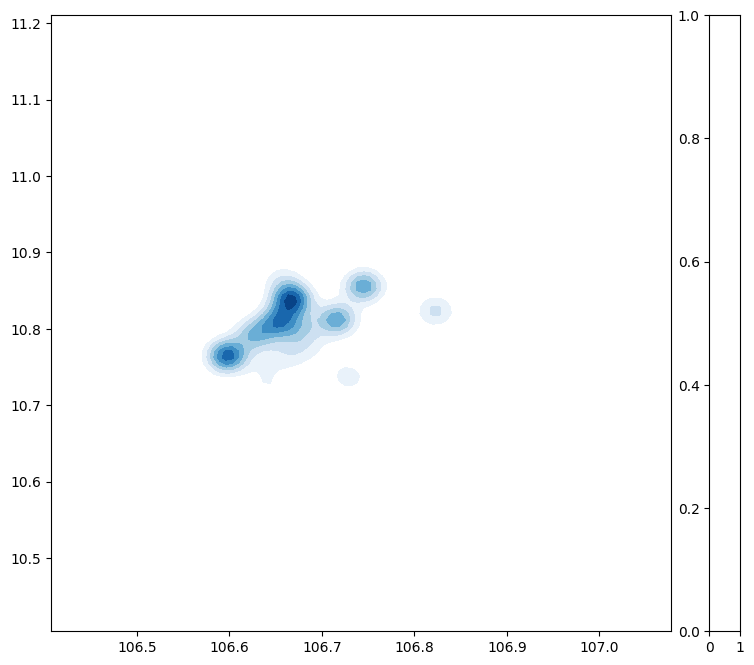

In [135]:
data = pd.read_csv('data_with_gadm.csv')

# Chuyển đổi cột 'geometry' sang GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.GeoSeries.from_wkt(data['geometry']))

# Trích xuất tọa độ trung tâm của mỗi quận
gdf['centroid'] = gdf.geometry.centroid.apply(lambda point: (point.x, point.y))

# Trích xuất tọa độ
coordinates = np.array(gdf['centroid'].tolist())

# Tạo KDE
kde = KernelDensity(bandwidth=0.015, metric='euclidean')
kde.fit(coordinates)

# Đánh giá KDE trên một lưới điểm
xmin, ymin, xmax, ymax = gdf.total_bounds
xgrid = np.linspace(xmin + 0.05, xmax + 0.05, 100)
ygrid = np.linspace(ymin + 0.05, ymax + 0.05, 100)
X, Y = np.meshgrid(xgrid, ygrid)
xy_sample = np.vstack([X.ravel(), Y.ravel()]).T
Z = kde.score_samples(xy_sample)
Z = np.exp(Z).reshape(X.shape)

# Vẽ heatmap
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels = np.linspace(20, 120, 8), cmap='Blues')
plt.colorbar(label = 'Density')
plt.title('Heatmap of House Density by District')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Vẽ bản đồ quận
gdf.boundary.plot(ax=plt.gca(), linewidth = 0.5, edgecolor='black')
plt.show()

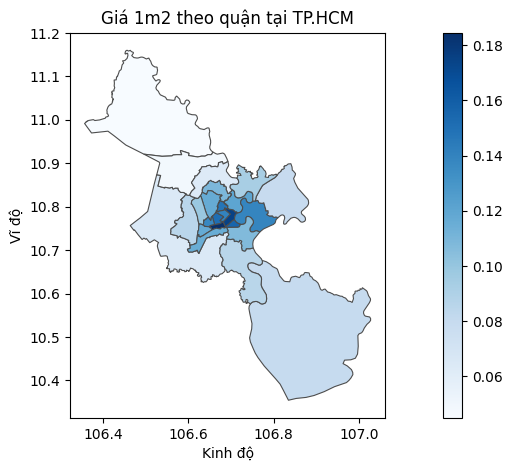

In [116]:
# Nhóm dữ liệu theo cột 'District' và tính giá trị trung bình của 'Price_per_sqm' cho mỗi quận
price_per_sqm_mean_by_district = df.groupby('District')['Price_per_sqm'].mean().reset_index()

# Đổi tên cột để rõ ràng hơn
price_per_sqm_mean_by_district.rename(columns={'Price_per_sqm': 'price_per_sqm_mean'}, inplace=True)

# Hợp nhất dữ liệu số lượng nhà bán với dữ liệu bản đồ hành chính
gdf = gdf_hcm.merge(price_per_sqm_mean_by_district, on='District')

# Vẽ bản đồ nhiệt
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

gdf.plot(column='price_per_sqm_mean', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)

plt.title('Giá 1m2 theo quận tại TP.HCM')
plt.xlabel('Kinh độ')
plt.ylabel('Vĩ độ')
plt.show()

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

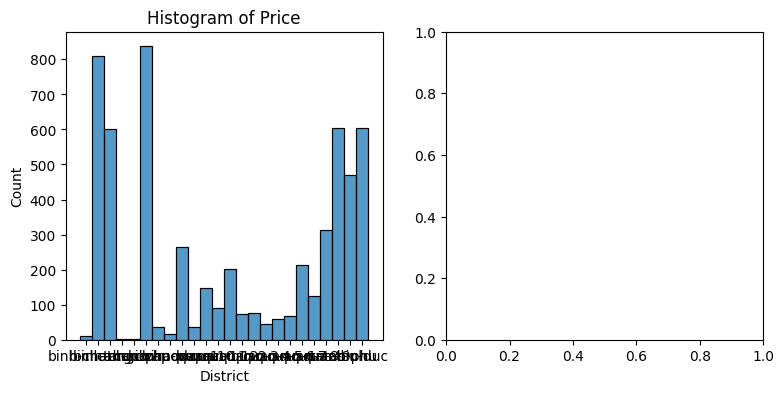

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
# Histogram
sns.histplot(df['District'], ax=axes[0], bins = 24)
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('District')
axes[0].set_ylabel('Count')

# KDE Plot
sns.kdeplot(df['District'], bw_adjust = 1.5, ax=axes[1],  fill=True, cmap='viridis')
axes[1].set_title('Kernel Density Estimation of Price')
axes[1].set_xlabel('District')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()